## EDA and Feature Engineering

Dataset basic informations :

Structural metadata : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths            

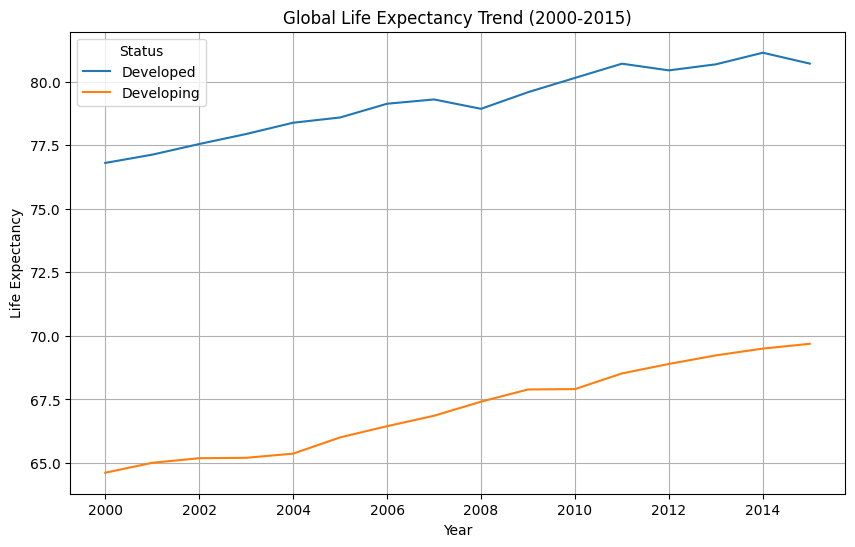

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Load data
df = pd.read_csv("Life Expectancy Data.csv")

# Basic info
print("Dataset basic informations :")


print("\nStructural metadata : ")
print(df.info()) # Number of rows and columns (data points and attributes)

print("\nSummary statistics : ")
print(df.describe().T)# Summary statistics of the dataset

# Separate numerical and categorical variables
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

print("Numerical Columns:", list(num_cols))
print("Categorical Columns:", list(cat_cols))


# Global Life Expectancy trends
life_exp = df[(df["Year"] >= 2000) & (df["Year"] <= 2015)].groupby(["Year","Status"])[["Life expectancy "]].mean(numeric_only=True).reset_index()

print(life_exp.head(50))

plt.figure(figsize=(10,6))
sns.lineplot(data=life_exp, x="Year", y="Life expectancy ",hue="Status")
plt.title("Global Life Expectancy Trend (2000-2015)")
plt.ylabel("Life Expectancy")
plt.xlabel("Year")
plt.grid(True)
plt.show()


## Features encoding and visualization

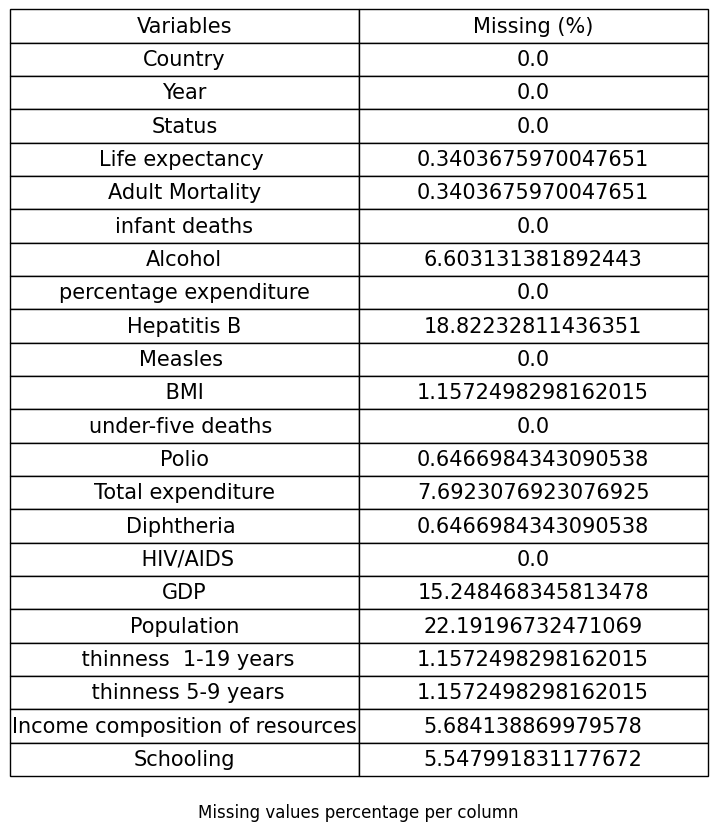

Feature with higher number of missing values (%): Population

Original: 12753375.120052494 61012096.508427925
Median Imputed: 10230851.228196053 54022417.455465995
KNN Imputed: 12753375.120052494 53815462.55693912


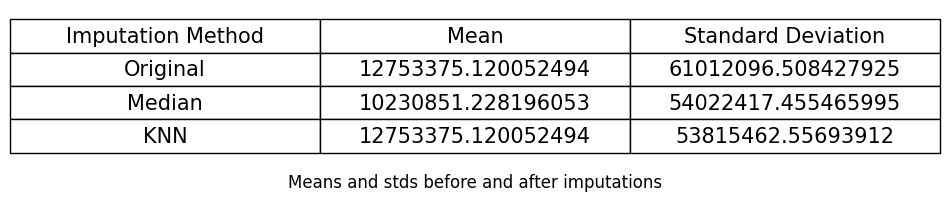

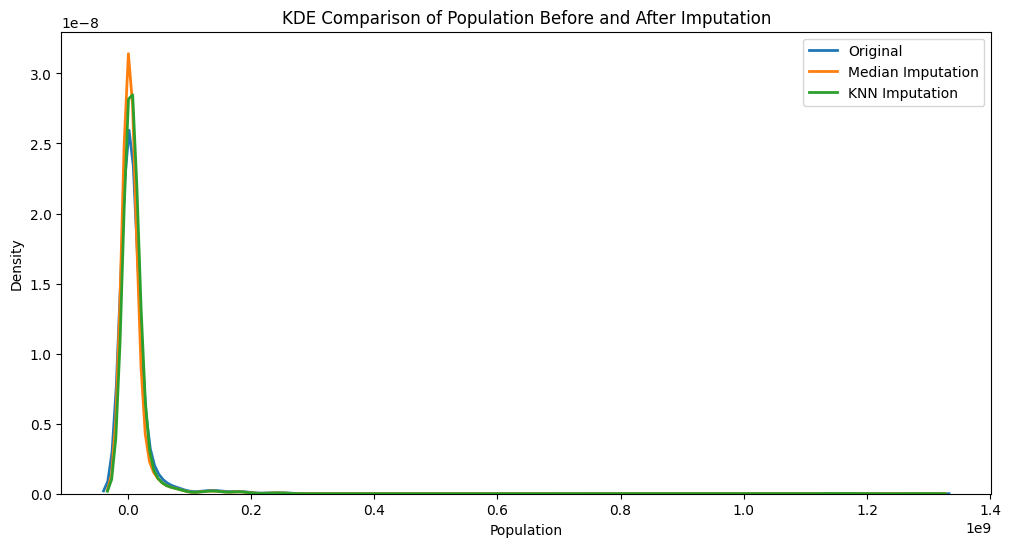


Outlier summary (IQR):
 [{'Variable': 'GDP', 'Outliers(number)': 365, 'Outilers(%)': 12.42}, {'Variable': 'percentage expenditure', 'Outliers(number)': 389, 'Outilers(%)': 13.24}]


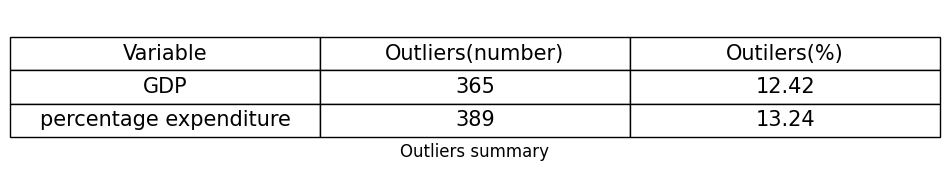

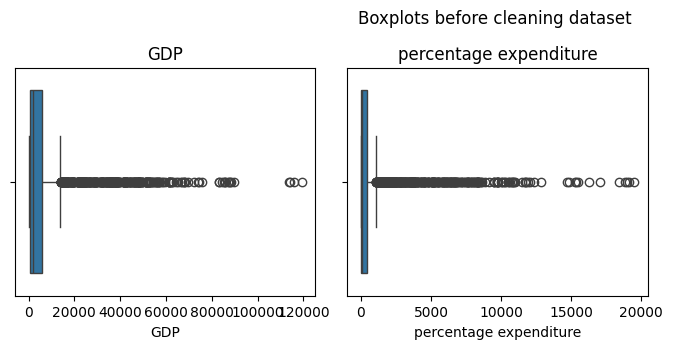

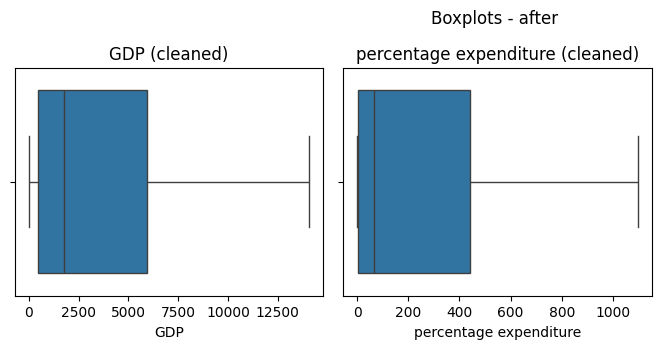

In [121]:
#Check Percentage of Missing Values
missing_percent = (df.isnull().sum() / len(df)) * 100


# Arrange the missing values data in a datframe
variables = list(missing_percent.index)
rows =  {
    'Variables':[],
    'Missing (%)':[]
    }
for i in range(len(variables)) :
    rows['Variables'].append(variables[i])
    rows['Missing (%)'].append(float(missing_percent.iloc[i]))
    
missing_vals = pd.DataFrame(rows)

# function to plot tables
def plot_table(data,title,col_width=1.5,col_height=2,title_y=0.0,font_size=15):
    table_data = pd.DataFrame(data)

    # Plot table
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('off')  # remove axis

    # Convert DataFrame to matplotlib table
    table = ax.table(
        cellText=table_data.values,       # table values
        colLabels=table_data.columns,     # column headers
        loc='center',
        cellLoc='center'
    )

    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)
    table.scale(col_width, col_height)

    plt.title(title,y=title_y, loc='center', pad=5) 
    plt.show()

#Visualize missing data
plot_table(missing_vals,"Missing values percentage per column",title_y=-2.3)



# Select the variable for imputation with higher number of missing values
var_higher_missing = missing_vals[missing_vals["Missing (%)"] == missing_vals["Missing (%)"].max()]["Variables"].values[0]
print(f"Feature with higher number of missing values (%): {var_higher_missing}")


# Median imputation
df_median = df.copy()
median_value = df_median[var_higher_missing].median()
df_median[var_higher_missing] = df_median[var_higher_missing].fillna(median_value)

# KNN Imputation
df_knn = df.copy()
knn_imputer = KNNImputer(n_neighbors=5)
df_knn[var_higher_missing] = knn_imputer.fit_transform(df_knn[[var_higher_missing]])

# Comparison of means and stds

print("\nOriginal:", df[var_higher_missing].mean(), df[var_higher_missing].std())
print("Median Imputed:", df_median[var_higher_missing].mean(), df_median[var_higher_missing].std())
print("KNN Imputed:", df_knn[var_higher_missing].mean(), df_knn[var_higher_missing].std())


rows = {"Imputation Method" : [],"Mean":[],"Standard Deviation":[]}

rows["Imputation Method"].append("Original")
rows["Mean"].append(df[var_higher_missing].mean())
rows["Standard Deviation"].append(df[var_higher_missing].std())

rows["Imputation Method"].append("Median")
rows["Mean"].append(df_median[var_higher_missing].mean())
rows["Standard Deviation"].append(df_median[var_higher_missing].std())

rows["Imputation Method"].append("KNN")
rows["Mean"].append(df_knn[var_higher_missing].mean())
rows["Standard Deviation"].append(df_knn[var_higher_missing].std())

#Visualize missing data
plot_table(rows,"Means and stds before and after imputations",col_width=2,title_y=-0.2)


# Plotting distributions before and after imputations
# Plotting KDE distributions before and after imputations
plt.figure(figsize=(12, 6))

# KDE for Original
sns.kdeplot(
    data=df[var_higher_missing], 
    label="Original", 
    linewidth=2
)

# KDE for Median Imputed
sns.kdeplot(
    data=df_median[var_higher_missing], 
    label="Median Imputation", 
    linewidth=2
)

# KDE for KNN Imputed
sns.kdeplot(
    data=df_knn[var_higher_missing], 
    label="KNN Imputation", 
    linewidth=2
)

plt.title(f"KDE Comparison of {var_higher_missing} Before and After Imputation")
plt.xlabel(var_higher_missing)
plt.ylabel("Density")
plt.legend()
plt.show()

# OUTLIER detection using IQR
# The distributions of numerical data are skewed or non-normal distributions, so we use IQR
# Outliers are data points that fall below (Q_1 - 1.5 * IQR)  or above (Q_3 + 1.5 * IQR).
cols = ["GDP", "percentage expenditure"]
def detect_outliers_iqr(series):
    s = series.dropna() # drop missing values
    q1 = s.quantile(0.25); # Q_1
    q3 = s.quantile(0.75); # Q_3
    iqr = q3 - q1 # IQR
    lower = q1 - 1.5*iqr;  # Q_1 - 1.5 * IQR
    upper = q3 + 1.5*iqr # Q_3 + 1.5 * IQR
    mask = (series < lower) | (series > upper) # range filter  below (Q_1 - 1.5 * IQR)  or above (Q_3 + 1.5 * IQR)
    return mask.fillna(False), lower, upper # return range filtered and bounds

# Outlier summary
outlier_summary_data = []
for c in cols: # for each column
    mask, low, up = detect_outliers_iqr(df[c]) # get range filter and bounds to detect outliers
    outlier_summary_data.append(
        {
            'Variable': c,
            'Outliers(number)': int(mask.sum()),
            'Outilers(%)': round(int(mask.sum())/len(df)*100,2)
        }
    )
    
print("\nOutlier summary (IQR):\n", outlier_summary_data)
#plot outliers summary table
plot_table(outlier_summary_data,"Outliers summary",col_width=2)


# Boxplots before handling
plt.figure(figsize=(10,6))
for i,c in enumerate(cols):
    plt.subplot(2,3,i+1); 
    #plt.boxplot(df[c].dropna()); 
    sns.boxplot(x=df[c].dropna())
    plt.title(c)
    
plt.suptitle("Boxplots before cleaning dataset")
plt.tight_layout(); 
plt.show()

# Clean dataset : handling outliers
df_clean = df_knn.copy()
        
# winsorization
all_outlier_indices = pd.Index([])
for c in cols:
    mask, low, up = detect_outliers_iqr(df_clean[c])
    
    # Clip values to the IQR bounds
    df_clean[c] = df_clean[c].clip(lower=low, upper=up)

    
# Boxplots after cleaning
plt.figure(figsize=(10,6))
for i,c in enumerate(cols):
    plt.subplot(2,3,i+1); 
    sns.boxplot(x=df_clean[c])
    plt.title(c + " (cleaned)")
    
plt.suptitle("Boxplots - after")
plt.tight_layout(); plt.show()

## Question 3

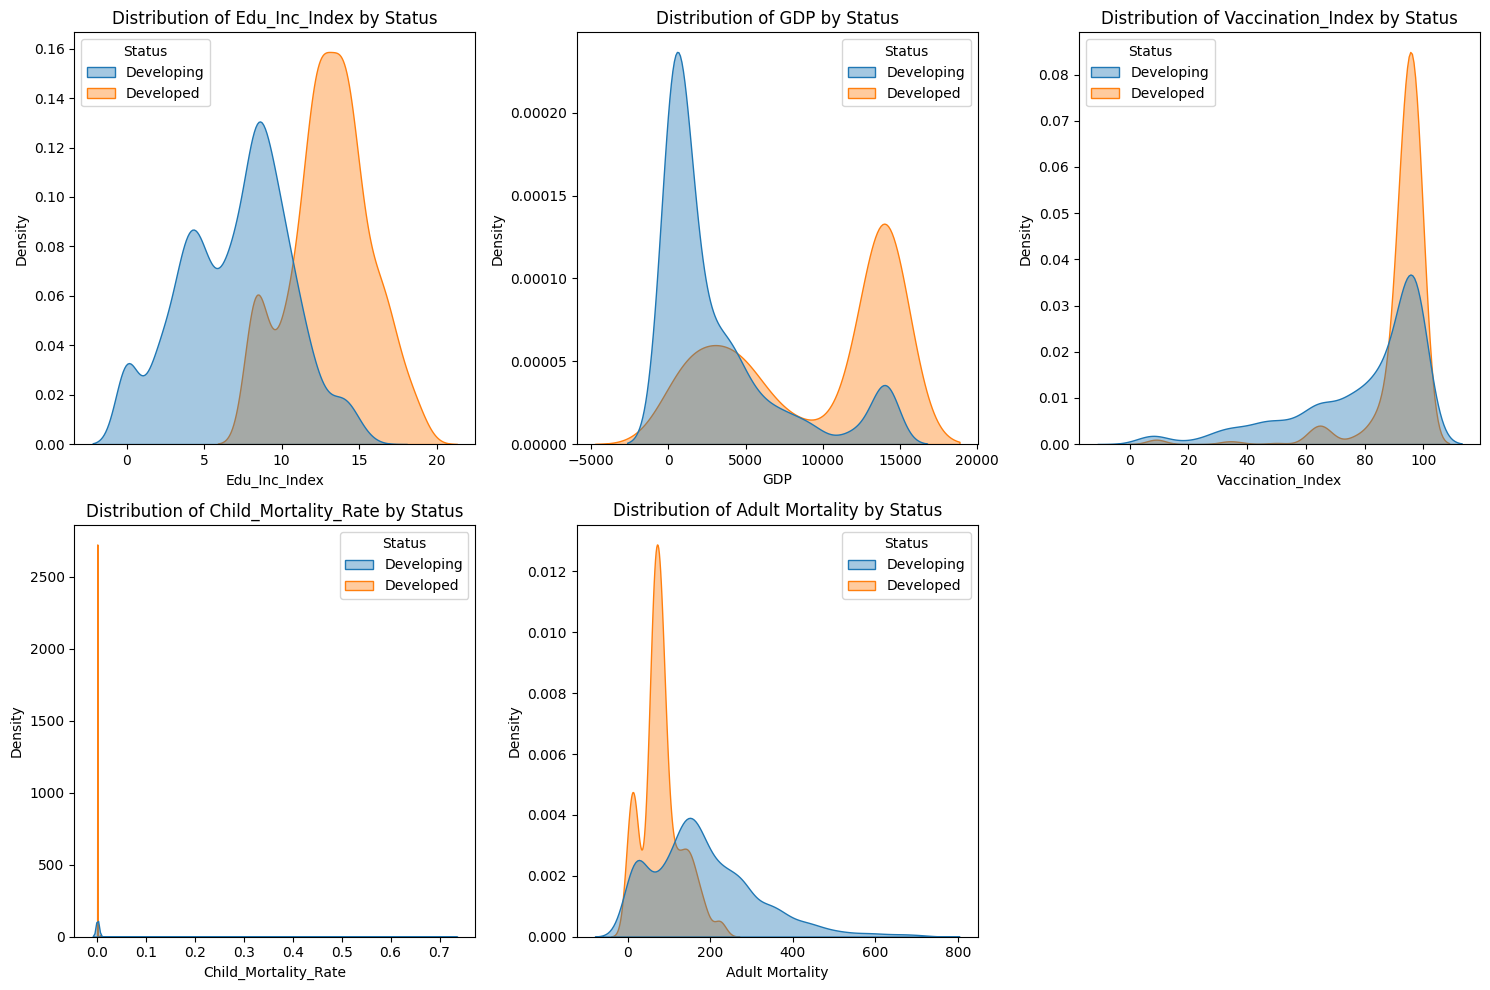

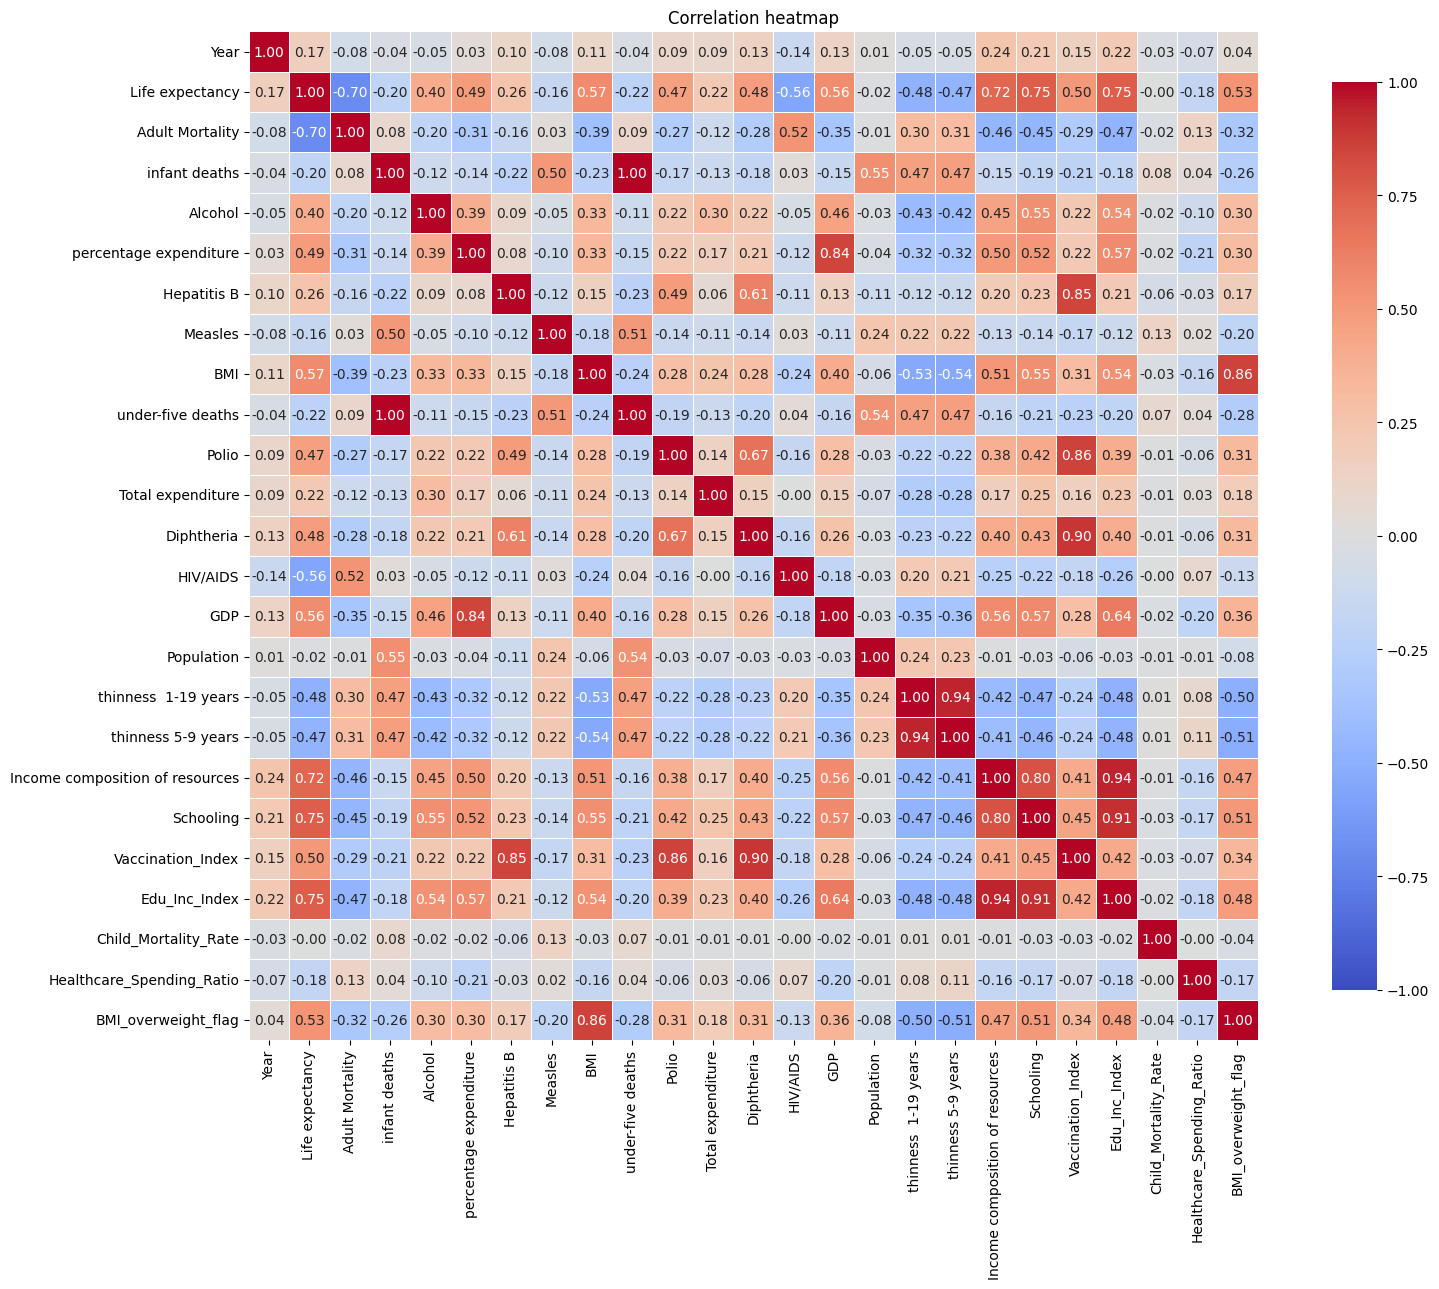

Top positive correlations with Life expectancy:
 Schooling                          0.751975
Edu_Inc_Index                      0.750588
Income composition of resources    0.724776
BMI                                0.567694
GDP                                0.557423
BMI_overweight_flag                0.529571
Vaccination_Index                  0.502534
percentage expenditure             0.488017
Name: Life expectancy, dtype: float64

Top negative correlations with Life expectancy:
 Measles                     -0.157586
Healthcare_Spending_Ratio   -0.177571
infant deaths               -0.196557
under-five deaths           -0.222529
thinness 5-9 years          -0.471584
thinness  1-19 years        -0.477183
HIV/AIDS                    -0.556556
Adult Mortality             -0.696359
Name: Life expectancy, dtype: float64


In [122]:
data = df_clean.copy()

# Clean column names
data.columns = [c.strip() for c in data.columns]

# Feature Engineering
# Vaccination index : mean of coverage columns when present
vax_cols = [c for c in ['Hepatitis B', 'Polio', 'Diphtheria'] if c in data.columns]
if vax_cols:
    data['Vaccination_Index'] = data[vax_cols].mean(axis=1)

# Education-Income Index
data['Edu_Inc_Index'] = data['Schooling'].fillna(data['Schooling'].median()) * \
                            data['Income composition of resources'].fillna(data['Income composition of resources'].median())

# Child mortality rate normalized by population (if population available)
pop = data['Population'].replace({0: np.nan})
data['Child_Mortality_Rate'] = (data['infant deaths'].fillna(0) + data['under-five deaths'].fillna(0)) / pop

# Healthcare spending ratio
data['Healthcare_Spending_Ratio'] = data['Total expenditure'] / data['GDP']

# BMI overweight flag
data['BMI_overweight_flag'] = (data['BMI'] > 25).astype(int)

# Visualizations 
# variables belived to have influence on the life expectancy
life_expectancy_vars = ['Edu_Inc_Index','GDP','Vaccination_Index','Child_Mortality_Rate','Adult Mortality']

plt.figure(figsize=(15,10))
for i, col in enumerate(life_expectancy_vars, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(
        data=data,
        x=col,
        hue="Status",
        fill=True,
        common_norm=False,
        alpha=0.4
    )
    plt.title(f"Distribution of {col} by Status")

plt.tight_layout()
plt.show()

# Correlation heatmap for numeric variables including engineered
life_expectancy_vars.append("Life expectancy")
#corr = data[life_expectancy_vars].corr()
numeric = data.select_dtypes(include=[np.number])
corr = numeric.corr()

#plt.figure(figsize=(14,10))
fig, ax = plt.subplots(figsize=(17, 13))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, center=0, vmin=-1, vmax=1,
            square=True, cbar_kws={"shrink": 0.9},ax=ax)
plt.title("Correlation heatmap")
plt.tight_layout(); 
plt.show()

corr_with_target = corr['Life expectancy'].drop('Life expectancy').sort_values(ascending=False)
print("Top positive correlations with Life expectancy:\n", corr_with_target.head(8))
print("\nTop negative correlations with Life expectancy:\n", corr_with_target.tail(8))


## Question 4

In [123]:
# Choose features and target
target = 'Life expectancy'
# Drop Year and Country for base modeling (Country is high-cardinality)
drop_cols = ['Country', 'Year'] if 'Country' in data.columns else ['Year'] if 'Year' in data.columns else []
X = data.drop(columns=[target] + [c for c in drop_cols if c in data.columns], errors='ignore')
y = data[target]

mask = ~y.isna()
X = X[mask]
y = y[mask]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

# Build transformers
numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p, validate=False)),  # for skewness
    ('scale', StandardScaler())
])

# For low-cardinality categoricals like Status we use one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, [c for c in cat_cols if c != 'Country'])  # avoid Country here
], remainder='drop')

# Example: transform once to view shapes
X_transformed = preprocessor.fit_transform(X)
print("Transformed feature matrix shape:", X_transformed.shape)

Numeric columns: ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Vaccination_Index', 'Edu_Inc_Index', 'Child_Mortality_Rate', 'Healthcare_Spending_Ratio', 'BMI_overweight_flag']
Categorical columns: ['Status']
Transformed feature matrix shape: (2928, 25)


## Question 5

Training: DecisionTree
DecisionTree -> RMSE: 2.503, MAE: 1.636, R2: 0.928
Training: RandomForest
RandomForest -> RMSE: 1.748, MAE: 1.093, R2: 0.965
Training: KNN
KNN -> RMSE: 3.016, MAE: 2.090, R2: 0.895
Training: GradientBoosting
GradientBoosting -> RMSE: 1.739, MAE: 1.162, R2: 0.965


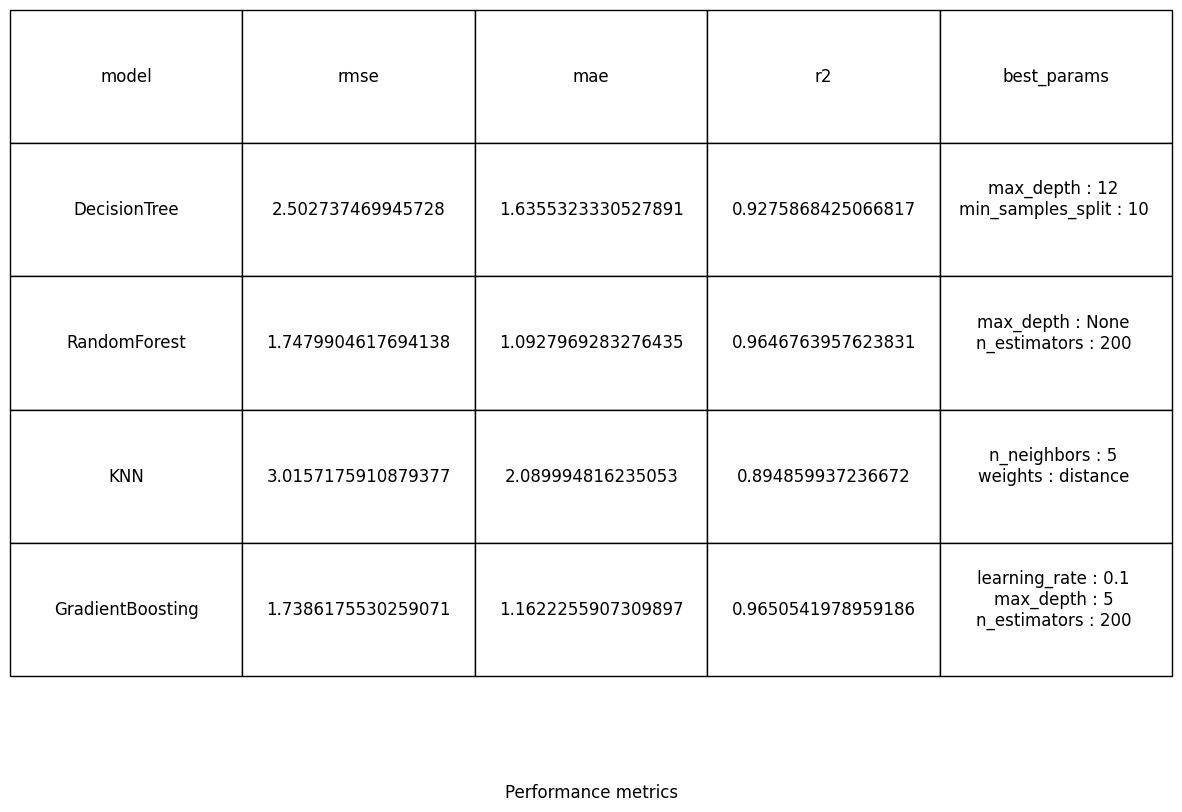

In [124]:

numeric_feature_names = numeric_cols  
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

X_transformed = pd.DataFrame(X_transformed, columns=feature_names)

# Train/test split using 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)

# Models and grids
models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'KNN': KNeighborsRegressor(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

# hyperparameters
param_grids = {
    'DecisionTree': {'model__max_depth': [3, 6, 12, None], 'model__min_samples_split': [2,5,10]},
    'RandomForest': {'model__n_estimators': [100,200], 'model__max_depth': [6, 12, None]},
    'KNN': {'model__n_neighbors': [3,5,10], 'model__weights': ['uniform','distance']},
    'GradientBoosting': {'model__n_estimators': [100,200], 'model__learning_rate': [0.01,0.1], 'model__max_depth': [3,5]}
}

results = {}
for name, estimator in models.items():
    print("Training:", name)
    pipe = Pipeline([('model', estimator)])
    grid = GridSearchCV(pipe, param_grids[name], cv=4,scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    preds = best.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    
    r2 = r2_score(y_test, preds)
    best_params = ''
    for param_name, param_value in grid.best_params_.items():
        best_params+= f"{param_name.replace('model__','')} : {param_value} \n"
    results[name] = {'model':name,'best_estimator': best, 'rmse': rmse, 'mae': mae, 'r2': r2, 'best_params_str': best_params,'best_params': grid.best_params_}
    print(f"{name} -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

# summary results
summary_df = pd.DataFrame({k: {'model':v['model'],'rmse':v['rmse'], 'mae':v['mae'], 'r2':v['r2'], 'best_params':v['best_params_str']} for k,v in results.items()}).T

plot_table(summary_df,"Performance metrics",col_width=2.5, col_height=8,title_y=-2.5,font_size=12)


## Question 6

Best model chosen: GradientBoosting
Top features:
                             feature  importance
11                         HIV/AIDS    0.593434
0                   Adult Mortality    0.145697
16  Income composition of resources    0.139665
19                    Edu_Inc_Index    0.022880
7                 under-five deaths    0.016304
6                               BMI    0.014846
17                        Schooling    0.010354
20             Child_Mortality_Rate    0.009561
15               thinness 5-9 years    0.009264
2                           Alcohol    0.008500
14             thinness  1-19 years    0.005132
9                 Total expenditure    0.003862
10                       Diphtheria    0.003363
8                             Polio    0.003178
1                     infant deaths    0.002897
3            percentage expenditure    0.002573
13                       Population    0.002054
5                           Measles    0.002033
4                       Hepatitis B  

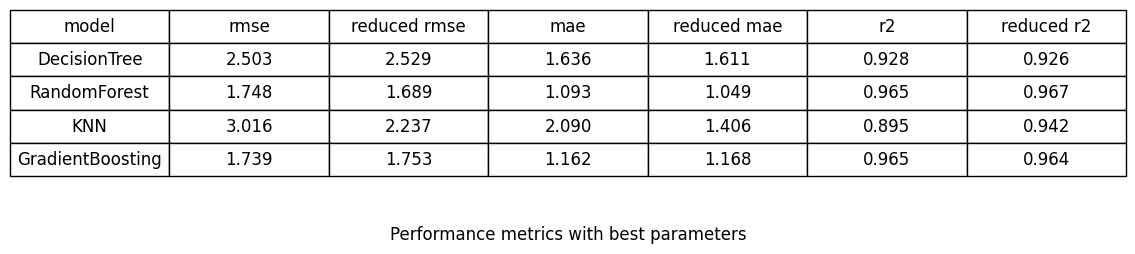

In [ ]:

# Identify best model by RMSE
best_name = min(results.keys(), key=lambda k: results[k]['rmse'])
print("Best model chosen:", best_name)
best_pipeline = results[best_name]['best_estimator']

# Extract importances
est = best_pipeline.named_steps['model']
if hasattr(est, 'feature_importances_'):
    importances = est.feature_importances_
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
else:
    # permutation importance fallback
    perm = permutation_importance(best_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': perm.importances_mean}).sort_values('importance', ascending=False)

print("Top features:\n", fi_df.head(30))

# Select top K features
K = 10 # 10 features
top_features = fi_df['feature'].head(K).tolist()
print("Top K preprocessed features:", top_features)

# Map preprocessed names back to original raw columns (simple heuristic)
selected_raw = set()
for f in top_features:
    # If feature equals a numeric raw column name, add it
    if f in X_train.columns:
        selected_raw.add(f)
    # If it's onehot like 'Status_Developing', split on '_' and check
    if "_" in f:
        prefix = f.split("_")[0]
        if prefix in X_train.columns:
            selected_raw.add(prefix)
# If mapping fails, fall back to selecting first K original numeric columns
if not selected_raw:
    selected_raw = list(X_train.columns[:K])
selected_raw = list(selected_raw)

selected_raw = [c for c in selected_raw if c in X_train.columns]
print("\n\nSelected raw columns for reduced model:", selected_raw)

# Build reduced preprocessor
num_cols_reduced = [c for c in selected_raw if c in X_train.select_dtypes(include=[np.number]).columns]
cat_cols_reduced = [c for c in selected_raw if c in X_train.select_dtypes(include=['object']).columns]

num_tr = Pipeline([('impute', SimpleImputer(strategy='median')),
                   ('log1p', FunctionTransformer(np.log1p, validate=False)),
                   ('scale', StandardScaler())])
cat_tr = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
                   ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preproc_reduced = ColumnTransformer([
    ('num', num_tr, num_cols_reduced),
    ('cat', cat_tr, cat_cols_reduced)
], remainder='drop')



new_results = {}
for name, estimator in models.items():
    print("Training again :", name)
    # Recreate best estimator with its tuned parameters
    best_params = results[name]['best_params']
    # Keep only parameters valid for THIS model
    valid_params = estimator.get_params().keys()
    
    estimator_kwargs = {}
    for k, v in best_params.items():
        if k.startswith("model__"):
            param_name = k.replace("model__", "")
        if param_name in valid_params:
            estimator_kwargs[param_name] = v

    ModelClass = estimator.__class__
    reduced_model = ModelClass(**estimator_kwargs)
    
    
    pipe_reduced = Pipeline([('model', reduced_model)])
    pipe_reduced.fit(X_train[selected_raw], y_train)
    preds_reduced = pipe_reduced.predict(X_test[selected_raw])

    rmse_red = np.sqrt(mean_squared_error(y_test, preds_reduced))
    mae_red = mean_absolute_error(y_test, preds_reduced)
    r2_red = r2_score(y_test, preds_reduced)


    results[name]['rmse'] = f"{results[name]['rmse']:.3f}"
    results[name]['mae'] = f"{results[name]['mae']:.3f}"
    results[name]['r2'] = f"{results[name]['r2']:.3f}"
    
    results[name]['reduced rmse'] = f"{rmse_red:.3f}"
    results[name]['reduced mae'] = f"{mae_red:.3f}"
    results[name]['reduced r2'] = f"{r2_red:.3f}"
    print(f"{name} -> RMSE: {rmse_red:.3f}, MAE: {mae_red:.3f}, R2: {r2_red:.3f}")

# summary results
summary_df = pd.DataFrame({k: {'model':v['model'],'rmse':v['rmse'], 'reduced rmse':v['reduced rmse'],  'mae':v['mae'], 'reduced mae':v['reduced mae'], 'r2':v['r2'],'reduced r2':v['reduced r2']} for k,v in results.items()}).T

plot_table(summary_df,"Performance metrics with best parameters",col_width=2.4,title_y=-0.5,font_size=12)


## Question 7

In [ ]:
corr_ranking = corr_with_target.drop(["Income composition of resources","Schooling"]).reset_index().rename(columns={'index':'feature', 'Life expectancy':'corr'})


# Top-5 by correlation and by model importance
top5_corr = corr_ranking.head(5)
top5_model = fi_df[fi_df["feature"] != "Income composition of resources"].head(5)

print("Top-5 features by simple correlation with Life expectancy:")
print(top5_corr)

print("\nTop-5 features by model-derived importance:")
print(top5_model)

Top-5 features by simple correlation with Life expectancy:
               feature      corr
0        Edu_Inc_Index  0.750588
1                  BMI  0.567694
2                  GDP  0.557423
3  BMI_overweight_flag  0.529571
4    Vaccination_Index  0.502534

Top-5 features by model-derived importance:
              feature  importance
11           HIV/AIDS    0.593434
0     Adult Mortality    0.145697
19      Edu_Inc_Index    0.022880
7   under-five deaths    0.016304
6                 BMI    0.014846
